
**Задание**: используя методы библиотеки pandas, произвести описательную статистику и визуализацию данных в выбранном датасете













Загружаем необходимые библиотеки.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

Загружаем датасет. В нем оказалось несколько некорректных рядов, пока что я решила просто их удалить.

In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/визуализация/goodreads-books-dataset.csv', 'r') as data_file:
  lines = data_file.readlines()
  print(len(lines))

ind = 0
while ind < len(lines):
  s = lines[ind].strip().split(',')
  if len(s) != 12:
    print(s)
    del lines[ind]
  else:
    ind += 1
print(len(lines))

11128
['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner', ' Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press']
['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net', ' one of the founding members of this Tolkien website)/Verlyn Flieger/Turgon (=David E. Smith)', '3.58', '1593600119', '9781593600112', 'eng', '400', '26', '4', '4/6/2004', 'Cold Spring Press']
['22128', 'Patriots (The Coming Collapse)', 'James Wesley', ' Rawles', '3.63', '156384155X', '9781563841552', 'eng', '342', '38', '4', '1/15/1999', 'Huntington House Publishers']
['34889', "Brown's Star Atlas: Showing All The Bright Stars With Full Instructions How To Find And Use Them For Navigational Purposes And Department Of Trade Examinations.", 'Brown', ' Son & Ferguson', '0.00', '0851742718', '9780851742717', 'eng', '49', '0', '0', '5/1/1977', 'Brown Son & Ferguson Ltd.']
11

In [4]:
from io import StringIO
df = pd.read_csv(StringIO(''.join(lines)), delim_whitespace=False)
df.rename(columns={'  num_pages': 'num_pages'}, inplace=True)
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


Проверяем, что все типы данных всех столбцов распознались верно.

In [ ]:
df.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

**1. Как статистически распределены рейтинги книг на сайте?**  
Нарисуем гистограмму распределения и приблизим наиболее информативный участок.



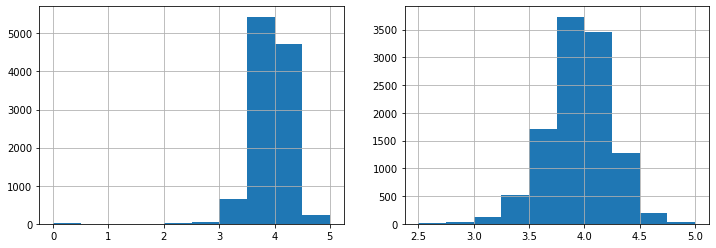

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df['average_rating'].hist(ax=axes[0], figsize=(12, 4));
df['average_rating'].hist(ax=axes[1], range=[2.5, 5], figsize=(12, 4));
plt.savefig('1.jpg')

Чаще всего книги получают оценки от **3.5** до **4.5**.  
Книги с рейтингом 0, скорее всего, пока не получили ни одной оценки. Таких книг 25:

In [ ]:
df[df['average_rating'] == 0]['bookID'].count()

25

**2. Как число текстовых отзывов на книгу соотносится с ее рейтингом?** Правда ли, что пользователи пишут отзывы на непонравившиеся книги чаще, чем на понравившиеся?  
Отфильтруем выбросы и построим график scatter plot.

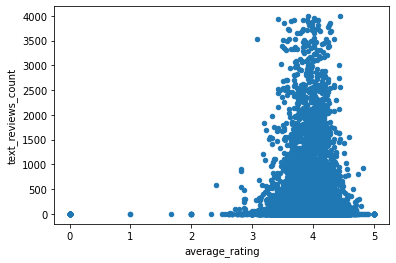

In [6]:
df.query('text_reviews_count < 4000').plot.scatter(x='average_rating', y='text_reviews_count');
plt.savefig('2.jpg')

Судя по графику, предположение неверно. Число текстовых отзывов и количество поставленных рейтингов (см. гистограмму выше) примерно одинаково распределены относительно величины рейтинга.

**3. У каких авторов самый высокий средний рейтинг?**  
Создадим датафрейм со столбцами "автор", "средний рейтинг книг автора" и "общее число книг автора в датасете".

In [16]:
authors_ratings = dict()
books_count = dict()
for _, row in df[['authors', 'average_rating']].iterrows():
  authors = row['authors'].split('/')
  for a in authors:
    authors_ratings[len(authors_ratings)] = [a, row['average_rating']]
    if a in books_count:
      books_count[a] += 1
    else:
      books_count[a] = 1

authors_ratings = pd.DataFrame.from_dict(data=authors_ratings, orient='index', 
                                         columns=['author', 'average_rating'])
authors_ratings['books_number'] = pd.Series([books_count[a] for a in authors_ratings['author']])
authors_ratings.head()

,author,average_rating,books_number
0,J.K. Rowling,4.57,25
1,Mary GrandPré,4.57,6
2,J.K. Rowling,4.49,25
3,Mary GrandPré,4.49,6
4,J.K. Rowling,4.42,25


Посмотрим, сколько в датасете строк и уникальных авторов:

In [5]:
authors_ratings['author'].size, authors_ratings['author'].nunique()

(19237, 9231)

Возьмем авторов, написавших не менее 3 книг, и отсортируем их по рейтингу по убыванию. Топ-десять получившегося списка изобразим на диаграмме.

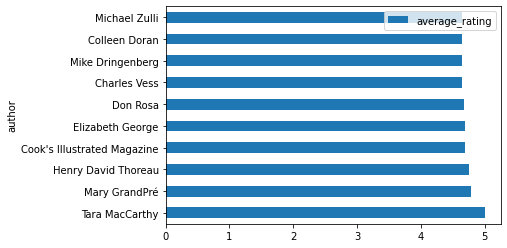

In [37]:
authors_ratings[(authors_ratings['books_number'] >= 3) & (authors_ratings['author'] != 'NOT A BOOK')] \
  .groupby('author')['average_rating'].apply(pd.Series.mode) \
  .sort_values(ascending=False).reset_index() \
  .iloc[:10].plot.barh(x='author', y='average_rating');
plt.savefig('3.jpg')

**4. Какие авторы написали больше всех книг?**  
Воспользуемся только что созданным датафреймом и найдем топ-десять авторов по числу написанных книг. Результат также изобразим на диаграмме.

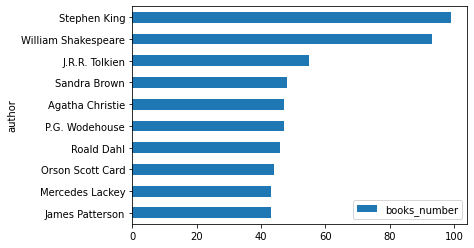

In [ ]:
authors_ratings = authors_ratings.drop_duplicates(subset=['author'])
fig = authors_ratings.sort_values(ascending=False, by='books_number').iloc[:10].\
  plot.barh(y='books_number', x='author');
fig.invert_yaxis()
plt.savefig('4.jpg')

**5. Книг на каком языке в датасете больше всего?**  
Сгруппируем датасет по языкам, посчитаем, сколько книг написано на каждом из них, и сохраним результат в отдельный датафрейм. Подавляющее большинство книг в датасете написано на английском языке; пропустим его, чтобы получить более репрезентативное изображение. Визуализируем процентное соотношение книг среди пяти самых частых языков в виде круговой диаграммы.

in english: 1629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


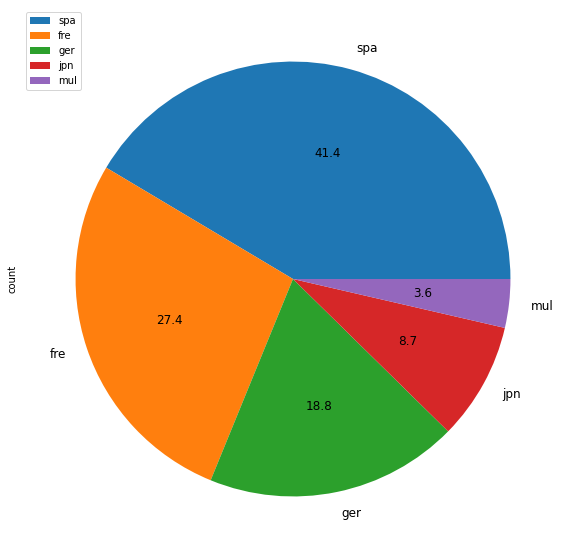

In [ ]:
languages_count = df.groupby('language_code')['language_code'].count().reset_index(name='count')

eng_sum = languages_count[languages_count['language_code'].str.contains('en-')]['count'].sum()
languages_count[languages_count['language_code'] == 'eng']['count'] += eng_sum
print('in english:', eng_sum)
languages_count.drop(languages_count.loc[languages_count['language_code'].str.contains('en-')].index, inplace=True)

languages_count = languages_count.sort_values(ascending=False, by='count').iloc[1:6]
languages_count.plot.pie(y='count', labels=languages_count['language_code'], 
                         autopct="%.1f", fontsize=12, figsize=(10, 10));
plt.savefig('5.jpg')

После английского языка больше всего книг в датасете написано на **испанском**, **французском** и **немецком**.

**6. Распределение числа страниц**  
Выведем минимальное, максимальное и медианное число страниц книг в датасете. Построим их распределение с помощью pandas-метода hist() и приблизим его наиболее информативный фрагмент.



pages: min = 0, max = 6576, median = 299


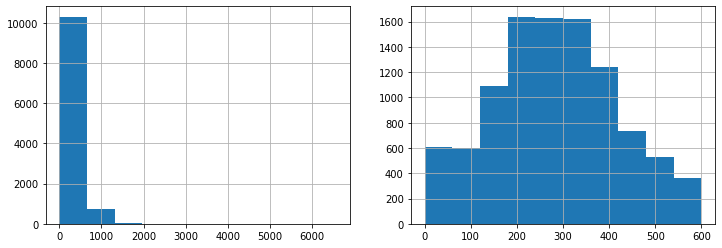

In [ ]:
print('pages: min = {}, max = {}, median = {}'.format(df['num_pages'].min(),
                                                      df['num_pages'].max(), 
                                                      round(df['num_pages'].median())))
fig, axes = plt.subplots(nrows=1, ncols=2)
df['num_pages'].hist(ax=axes[0], figsize=(12, 4));
df['num_pages'].hist(ax=axes[1], range=[0, 600], figsize=(12, 4));
plt.savefig('6.jpg')

Большая часть книг в датасете длиной от **200** до **400** страниц.



**7. Какие авторы написали самые длинные книги?**  
Отсортируем строки по убыванию номера страниц. Отобразим топ-десять авторов на диаграмме, исключив из рассмотрения анонимных авторов и J.K. Rowling/Mary GrandPré (J.K. Rowling и так входит в этот топ, к тому же, Mary GrandPré иллюстрировала произведения Роулинг, но не была их автором).

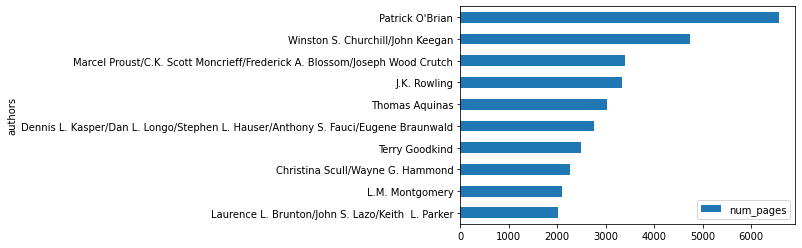

In [38]:
fig = df[['authors', 'num_pages']].sort_values(ascending=False, by='num_pages'). \
  query('authors not in ["Anonymous", "J.K. Rowling/Mary GrandPré"]'). \
  iloc[:10].plot.barh(x='authors', y='num_pages');
fig.invert_yaxis()
plt.savefig('7.jpg')

**8. Как рейтинг книги зависит от числа страниц?**  
Отфильтровав записи о книгах, построим график scatter-plot, где по горизонтальной оси отложено число страниц, а по вертикальной - средний рейтинг книги данной длины. 

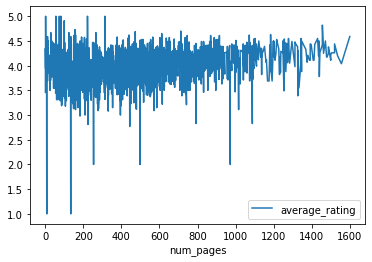

In [8]:
pages_rating = df[['num_pages', 'average_rating']].query('0 < num_pages <= 1600 & average_rating != 0')
pages_rating.groupby('num_pages')['average_rating'].apply(pd.Series.mode).reset_index(). \
  plot(x='num_pages', y='average_rating');
plt.savefig('8.jpg')

**9. Как количество публикуемых книг менялось со временем?**  
Создадим отдельный датафрейм, где посчитаем, сколько книг было издано в какой год.

In [ ]:
published_over_time = df[['bookID', 'publication_date']]

years = []
for v in published_over_time['publication_date']:
  years.append(int(v.split('/')[2]))
published_over_time['year'] = pd.Series(years)

published_over_time = published_over_time.groupby('year')['bookID'].count().reset_index(name='books_number')
published_over_time.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,books_number
0,1900,1
1,1913,1
2,1914,1
3,1919,1
4,1921,2


Построим график зависимости числа книг от года их издания (слева). Очевидно, в датафрейме в основном представлены книги, изданные в промежуток с **1975** по **2007** год. Построим дополнительный график, чтобы рассмотреть этот участок кривой (справа).

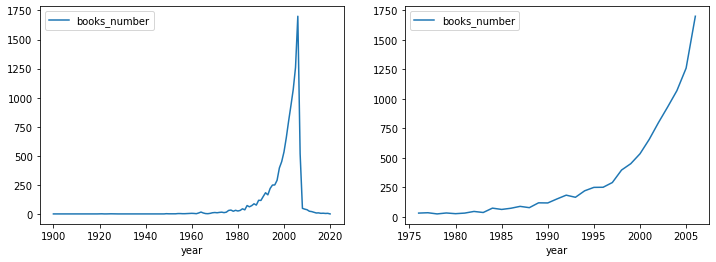

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
published_over_time.plot(ax=axes[0], x='year', y='books_number', figsize=(12, 4));
published_over_time.query('1975 < year < 2007').plot(ax=axes[1], x='year', y='books_number', figsize=(12, 4));
plt.savefig('9.jpg')

**10. Какое издательство печатает больше всех книг?**  
Создадим датафрейм со столбцами "издательство" и "число изданных им книг". Отсортируем список по числу книг и отобразим топ-десять на диаграмме.

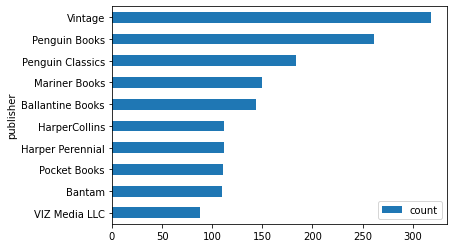

In [4]:
publishers =  df.groupby('publisher')['publisher'].count().reset_index(name='count')
fig = publishers.sort_values(ascending=False, by='count').iloc[:10].plot.barh(x='publisher', y='count');
fig.invert_yaxis()
plt.savefig('10.jpg')

**11. У какого издательства самый высокий средний рейтинг?**  
Дополним датафрейм столбцом со средним рейтингом книг, изданных издательством. Среди издательств, напечатавших хотя бы 20 книг, выявим топ-десять по рейтингу и изобразим результат на диаграмме.

In [13]:
publishers['average_rating'] = df.groupby('publisher')['average_rating'].apply(pd.Series.mode). \
  reset_index()['average_rating']

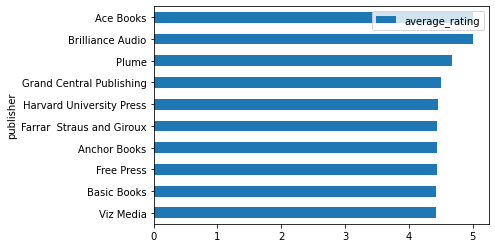

In [15]:
fig = publishers.query('count >= 20').sort_values(ascending=False, by='average_rating'). \
  iloc[:10].plot.barh(x='publisher', y='average_rating');
fig.invert_yaxis()
plt.savefig('11.jpg')